# Statistical Learning
## SuS4 project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, HuberRegressor, RidgeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
import xgboost as xgb
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score, GridSearchCV, train_test_split, cross_validate, KFold
import warnings
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, confusion_matrix
from scipy.stats import skew
from sklearn import preprocessing
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from matplotlib import pyplot as plt
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.feature_selection import SelectFromModel
import time
from sklearn import tree, svm
from sklearn.naive_bayes import GaussianNB
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
np.random.seed(666)

#### The dataset of the competition was provided by Findomestic, with a total of almost 67000 users' approved financial request. Each row of the dataset contain a single request and the 30 columns represent some charactetistics of the user.

#### When a user makes a financial request their behaviour is observed for 24 months and classified as "cliente regolare" (denoted with the number 0), "cliente con contenzioso" (denoted with the number 1), "cliente in recupero" (denoted with the number 2). Our aim is to predict the class of almost 27000 users in the testset exploiting the trainset data.

In [2]:
#reading train and test
train = pd.read_csv('dataset_stima.csv', index_col=0)
test = pd.read_csv('dataset_verifica.csv', index_col=0)
test.drop(['X', 'ID'], axis=1, inplace=True)
train.shape, test.shape

((40000, 30), (26521, 29))

In [3]:
#summary of train dataset
train.describe()

,REGIONE,ANZ_RES,ANZ_BAN,ANZ_PROF,NUM_FIGLI,NAZ_NASCITA,PROFESSIONE,REDDITO_CLT,REDDITO_FAM,AGE,score_cmp_qe,score_cmp_cb,num_sal_rec,num_mes_rec,ClientStatus,num_rit_ori,canale_fin,NUM_PRA_pp,esposizione_pp,durata_residua_pp,NUM_PRA_cc,esposizione_cc,durata_residua_cc,NUM_SAL_PP,NUM_SAL_CC,NUM_PRA_cp,esposizione_cp
count,39997.000000,40000.000000,39973.000000,40000.00000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.00000,40000.00000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,9.636448,41.259000,27.935381,33.44595,0.902675,1.024775,5.242925,1348.567100,2014.199475,47.287675,32.037875,18.113800,0.033425,0.04630,0.04655,0.003025,3.580250,0.334125,4003.160019,16.933875,0.185325,326.296741,2.265500,0.173625,0.316100,0.472675,579.604314
std,5.592369,39.668392,36.791903,38.30834,0.954450,0.242307,1.371663,982.644301,1281.075970,11.895846,21.425843,2.432642,0.205448,0.33077,0.24410,0.060133,1.703462,0.521960,8173.765508,29.206498,0.462369,1688.133289,7.951113,0.462152,0.643421,0.665819,1454.370655
min,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,1.000000,19.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-3.000000,0.000000,0.000000,0.000000,-6900.000000
25%,5.000000,7.000000,4.000000,6.00000,0.000000,1.000000,4.000000,984.000000,1329.000000,38.000000,19.000000,18.000000,0.000000,0.00000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.000000,14.000000,9.000000,11.00000,1.000000,1.000000,6.000000,1236.000000,1743.000000,47.000000,32.000000,18.000000,0.000000,0.00000,0.00000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15.000000,86.000000,33.000000,83.00000,2.000000,1.000000,6.000000,1554.000000,2487.000000,57.000000,45.000000,19.000000,0.000000,0.00000,0.00000,0.000000,5.000000,1.000000,4550.982500,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,21.000000,99.000000,99.000000,99.00000,3.000000,6.000000,8.000000,96723.000000,96923.000000,79.000000,210.000000,20.000000,4.000000,11.00000,2.00000,3.000000,5.000000,5.000000,74996.270000,99.000000,6.000000,43486.920000,99.000000,8.000000,8.000000,5.000000,20184.970000


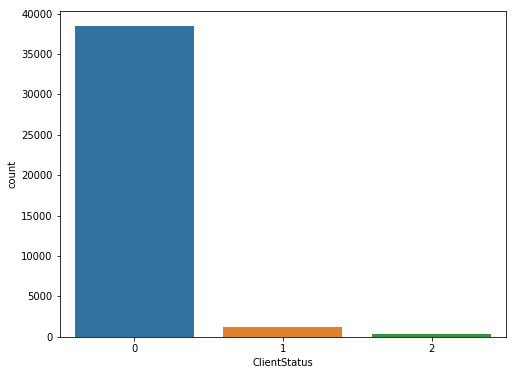

In [4]:
#plot target distribution
plt.figure(1, figsize=(8, 6))
sns.countplot(train['ClientStatus'])
plt.show()

In [7]:
print("clienti regolari: " , "\t ", round(len(train[train['ClientStatus'] == 0])/len(train)*100,2), "%")
print("clienti con contenzioso: " , round(len(train[train['ClientStatus'] == 1])/len(train)*100,2), "%")
print("clienti in recupero: \t " , round(len(train[train['ClientStatus'] == 2])/len(train)*100,2), "%")

clienti regolari:  	  96.1 %
clienti con contenzioso:  3.14 %
clienti in recupero: 	  0.76 %


#### From the histogram above it is clear that ClientStatus class distributions are unbalanced. There are too many regular clients, while the others are less than 4%. This could be a problem in the training phase, because there could be not enough data to predict clients belonging to class 2. We will use a specific tool to balance the data later.

#### In the following step we check for  NAs in the trainset and the testset.

In [8]:
#na train set
pd.concat((pd.DataFrame(train[train['ClientStatus'] == 0].isnull().sum()[train.isnull().sum() != 0], columns=['NAs 0']),
           pd.DataFrame(train[train['ClientStatus'] == 1].isnull().sum()[train.isnull().sum() != 0], columns=['NAs 1']), 
           pd.DataFrame(train[train['ClientStatus'] == 2].isnull().sum()[train.isnull().sum() != 0], columns=['NAs 2']),
           pd.DataFrame(train.isnull().sum()[train.isnull().sum() != 0], columns=['NAs TOT'])), axis = 1)

,NAs 0,NAs 1,NAs 2,NAs TOT
REGIONE,3,0,0,3
ANZ_BAN,26,1,0,27


In [9]:
#na test set
pd.DataFrame(test.isnull().sum()[test.isnull().sum() != 0], columns=['NAs'])

,NAs
REGIONE,5
ANZ_BAN,27


#### Since the percentage of rows with NAs values is close to 0, we decided to remove those observations.

In [10]:
train.dropna(inplace=True)
test.fillna(-999, inplace=True)
train.drop('REGIONE', axis=1, inplace=True)
test.drop('REGIONE', axis=1, inplace=True)

### Data visualization

#### There are both numerical features and categorical features in the data. We distinguished each feature between categorical and numeric in order to simplify the next steps. We will convert the categorical variables in dummy variables (boolean variables) to obtain only numeric features and exclude extreme outlayers for the original numeric variables.

In [11]:
# Separate input features (X) and target variable (y)
y = train.ClientStatus
X = train.drop('ClientStatus', axis=1)
X_init = X

categ_features = ['RESIDENZA', 'STA_CIVILE', 'SESSO', 
                  'PROFESSIONE', 'NAZ_NASCITA', 'canale_fin', 'score_cmp_cb']

for feat in categ_features:
    X[feat] = X[feat].astype('category')
    test[feat] = test[feat].astype('category')

numeric_features = list(set(X.columns) - set(X.select_dtypes(include=['category']).columns))

In [12]:
#getting dummies of train dataset
X = pd.get_dummies(X)
test = pd.get_dummies(test)

In [13]:
print(X.columns)
X = X.reset_index(drop=True)
X.shape, test.shape

Index(['ANZ_RES', 'ANZ_BAN', 'ANZ_PROF', 'NUM_FIGLI', 'REDDITO_CLT',
       'REDDITO_FAM', 'AGE', 'score_cmp_qe', 'num_sal_rec', 'num_mes_rec',
       'num_rit_ori', 'NUM_PRA_pp', 'esposizione_pp', 'durata_residua_pp',
       'NUM_PRA_cc', 'esposizione_cc', 'durata_residua_cc', 'NUM_SAL_PP',
       'NUM_SAL_CC', 'NUM_PRA_cp', 'esposizione_cp', 'SESSO_F', 'SESSO_M',
       'STA_CIVILE_C', 'STA_CIVILE_D', 'STA_CIVILE_K', 'STA_CIVILE_M',
       'STA_CIVILE_V', 'STA_CIVILE_X', 'NAZ_NASCITA_1', 'NAZ_NASCITA_2',
       'NAZ_NASCITA_3', 'NAZ_NASCITA_4', 'NAZ_NASCITA_5', 'NAZ_NASCITA_6',
       'PROFESSIONE_0', 'PROFESSIONE_1', 'PROFESSIONE_2', 'PROFESSIONE_3',
       'PROFESSIONE_4', 'PROFESSIONE_5', 'PROFESSIONE_6', 'PROFESSIONE_7',
       'PROFESSIONE_8', 'RESIDENZA_A', 'RESIDENZA_E', 'RESIDENZA_F',
       'RESIDENZA_L', 'RESIDENZA_P', 'RESIDENZA_X', 'score_cmp_cb_0',
       'score_cmp_cb_18', 'score_cmp_cb_19', 'score_cmp_cb_20', 'canale_fin_1',
       'canale_fin_3', 'canale_fin_4', 'cana

((39970, 58), (26521, 58))

In [14]:
a = time.time()
print(len(X))
for i in numeric_features:
    arr = X[i]
    mean = np.mean(X[i])
    sd = np.std(X[i])
    mean, sd
    rejected = []
    final_list = arr
    for x in range(len(arr)-1,-1,-1):
        if (((arr[x] < mean - 5 * sd) or (arr[x] > mean + 5 * sd)) and y[x] == 0):
            rejected.append(arr[x])
            X = X.drop(X.index[x])
            y = y.drop(y.index[x])
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

print(len(X))
time.time() - a

39970
37646


41.11630463600159

### Balancing data

#### The SMOTEENN is used to balance the train dataset. SMOTE function perform an oversampling, generating new "SMOTEd" data set that addresses the class unbalance problem. ENN (edited nearest neighbours) removes examples whose class label differs from the class of at least half of its k nearest neighbors.

In [15]:
# splitting train in training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state = 666)

In [29]:
a = time.time()
smote_enn = SMOTEENN(smote=SMOTE(n_jobs=4), random_state=666)
X_resampled, y_resampled = smote_enn.fit_sample(X_train, y_train)
time.time() - a

28.268877029418945

#### The next plot shows more balance between the 3 classes after applying the SMOTEENN function. 

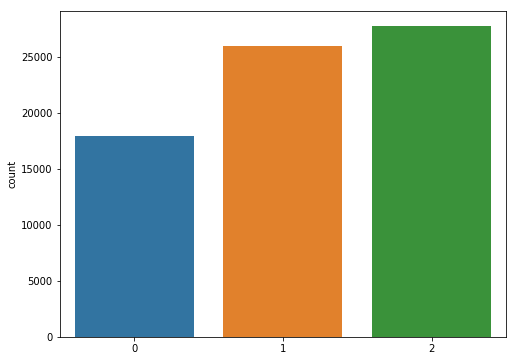

In [30]:
#plot target distribution of balanced dataset
plt.figure(1, figsize=(8, 6))
sns.countplot(y_resampled)
plt.show()

In [31]:
X_train, y_train = pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['ClientStatus'])

### Features selection


#### To select the best features we exploited the XGBoost (eXtreme Gradient Boosting) algorithm, an implementation of gradient boosted decision trees engineered for efficiency of compute time and memory resources, that returns also a sort of score for the importance of the features.

#### In the next chunk of code we analyzed the correlation between features.

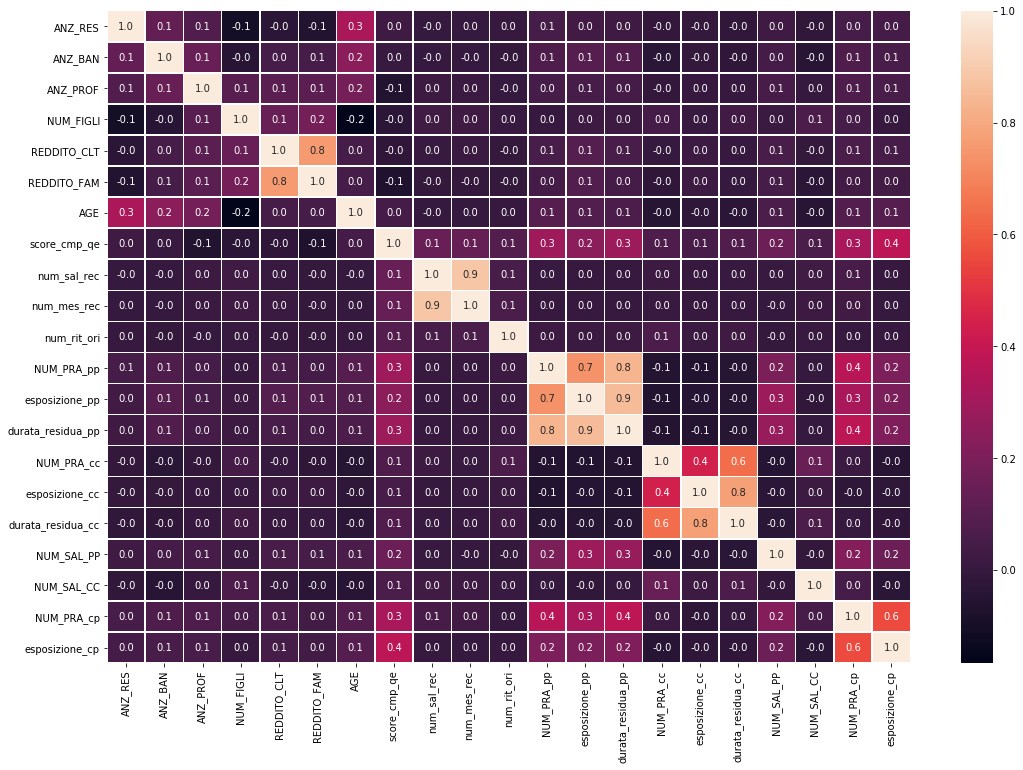

In [32]:
f,ax = plt.subplots(figsize=(18, 12))
sns.heatmap(X_init.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [33]:
pd.concat((X_train[['esposizione_pp', 'durata_residua_pp']], y), axis=1).corr()

,esposizione_pp,durata_residua_pp,ClientStatus
esposizione_pp,1.000000,0.884192,0.003047
durata_residua_pp,0.884192,1.000000,0.002806
ClientStatus,0.003047,0.002806,1.000000


In [34]:
pd.concat((X_train[['num_mes_rec', 'num_sal_rec']], y), axis=1).corr()

,num_mes_rec,num_sal_rec,ClientStatus
num_mes_rec,1.000000,0.904227,0.005021
num_sal_rec,0.904227,1.000000,0.007240
ClientStatus,0.005021,0.007240,1.000000


#### We dropped 2 columns in our dataset because the correlation between those features and other features was almost 0.9.

In [35]:
X.drop('num_mes_rec', axis=1, inplace=True)
test.drop('num_mes_rec', axis=1, inplace=True)
X.drop('durata_residua_pp', axis=1, inplace=True)
test.drop('durata_residua_pp', axis=1, inplace=True)

In [36]:
# xgboost to evaluate feature importance
a = time.time()
model = XGBClassifier(random_state=1, n_jobs=4)
model.fit(X_train, y_train)
time.time() - a

18.69215488433838

#### Feature selection using the XGBoost algorithm

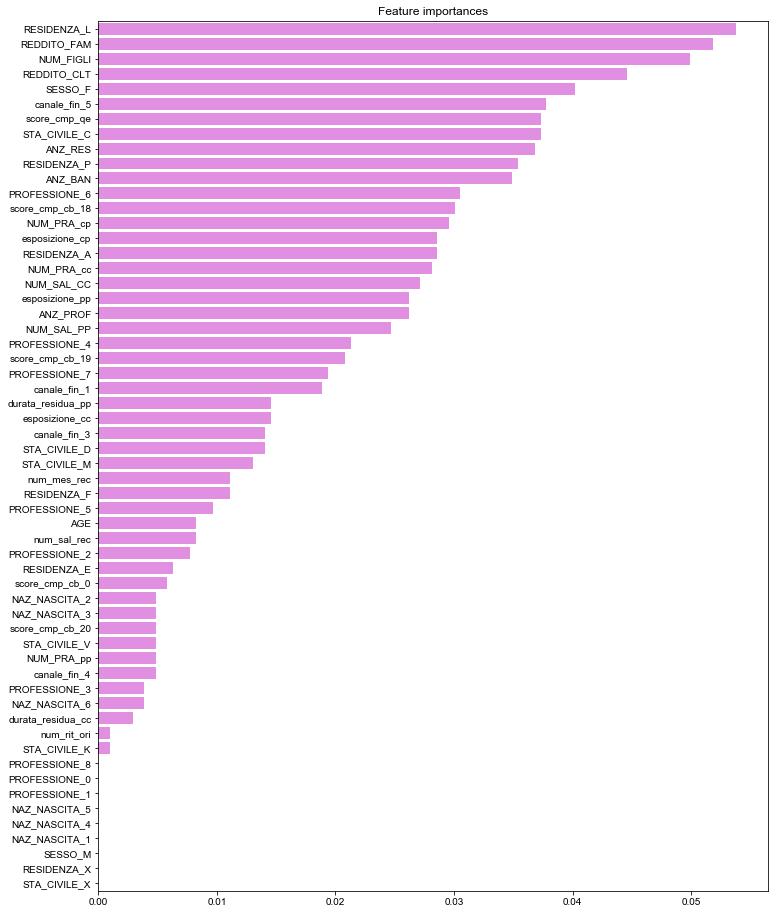

In [37]:
importances = model.feature_importances_[:]
indices = np.argsort(importances)[::-1]

plt.figure(1, figsize=(12, 16))
plt.title("Feature importances")
sns.set(style="whitegrid")
sns.barplot(x=importances[indices], y=X_train.columns[indices], color="violet")
plt.show()

#### The next step aims to find the accuracy with respect to a threshold for the importance score of the variables. When threshold grows the features used in the XGBoost classifier decrease.

In [38]:
# finding the best threshold according to the min error in the validation set
for alpha in np.arange(0, 0.041, 0.003):
    # select features using threshold alpha
    selection = SelectFromModel(model, threshold=alpha, prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_test = selection.transform(X_test)
    # train model
    selection_model = XGBClassifier(random_state = 1, n_jobs=4)
    selection_model.fit(select_X_train, y_train)
    # eval model
    y_pred = selection_model.predict(select_X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    #a = conf_mat * LM
    #print('alpha: ' + str(round(alpha, 3)) + '\tError: ' + str((a.sum()/len(y_pred))/err_max))
    acc = np.sum(np.diag(conf_mat))/len(y_pred)
    print('alpha: ' + str(round(alpha, 3)) + '\tAccuracy: ' + str(acc))

alpha: 0.0	Accuracy: 0.9530671470029021
alpha: 0.003	Accuracy: 0.952466726708696
alpha: 0.006	Accuracy: 0.9521665165615931
alpha: 0.009	Accuracy: 0.9537676373461423
alpha: 0.012	Accuracy: 0.953367357150005
alpha: 0.015	Accuracy: 0.9529670769538677
alpha: 0.018	Accuracy: 0.9529670769538677
alpha: 0.021	Accuracy: 0.9511658160712498
alpha: 0.024	Accuracy: 0.9480636445511859
alpha: 0.027	Accuracy: 0.949964975482838
alpha: 0.03	Accuracy: 0.957069948964275
alpha: 0.033	Accuracy: 0.9406584609226458
alpha: 0.036	Accuracy: 0.941959371560092
alpha: 0.039	Accuracy: 0.9193435404783349


In [39]:
best_threshold = 0.015

### Model selection


#### The model used are: Decision Tree Classifier, XGBoost, Naive Bayes, Random Forest, AdaBoost and Ridge Classifier.

In [40]:
selection = SelectFromModel(model, threshold=best_threshold, prefit=True)
X_train = selection.transform(X_train)
X_test = selection.transform(X_test)

In [79]:
kf = StratifiedKFold(n_splits=10, random_state=666)

###### DecisionTreeClassifier

In [80]:
algorithm = tree.DecisionTreeClassifier()
cv_score = cross_validate(algorithm, X_train, y_train, scoring='accuracy', cv=kf, verbose=True, n_jobs=4)
algorithm.fit(X_train, y_train)
y_pred = algorithm.predict(X_test)
conf_mat_lo_test = confusion_matrix(y_test, y_pred)
acc_lo_test = np.sum(np.diag(conf_mat_lo_test))/len(y_pred)
print('test_accuracy: ' + str(np.mean(cv_score['test_score'])) + '\t' + 
          'leave_out_test_accuracy: ' + str(acc_lo_test))

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    5.2s finished


test_accuracy: 0.9508986985320377	leave_out_test_accuracy: 0.8740276577355229


##### XGBoost

In [81]:
algorithm = XGBClassifier()
cv_score = cross_validate(algorithm, X_train, y_train, scoring='accuracy', cv=kf, verbose=True, n_jobs=4)
algorithm.fit(X_train, y_train)
y_pred = algorithm.predict(X_test)
conf_mat_lo_test = confusion_matrix(y_test, y_pred)
acc_lo_test = np.sum(np.diag(conf_mat_lo_test))/len(y_pred)
print('test_accuracy: ' + str(np.mean(cv_score['test_score'])) + '\t' + 
          'leave_out_test_accuracy: ' + str(acc_lo_test))

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   58.5s finished


test_accuracy: 0.8493665805645912	leave_out_test_accuracy: 0.9471694036300777


##### NaiveBayes

In [82]:
algorithm = GaussianNB()
cv_score = cross_validate(algorithm, X_train, y_train, scoring='accuracy', cv=kf, verbose=True, n_jobs=4)
algorithm.fit(X_train, y_train)
y_pred = algorithm.predict(X_test)
conf_mat_lo_test = confusion_matrix(y_test, y_pred)
acc_lo_test = np.sum(np.diag(conf_mat_lo_test))/len(y_pred)
print('test_accuracy: ' + str(np.mean(cv_score['test_score'])) + '\t' + 
          'leave_out_test_accuracy: ' + str(acc_lo_test))

test_accuracy: 0.5462155111494156	leave_out_test_accuracy: 0.5104796888504753


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.6s finished


##### RandomForest

In [83]:
algorithm = RandomForestClassifier()
cv_score = cross_validate(algorithm, X_train, y_train, scoring='accuracy', cv=kf, verbose=True, n_jobs=4)
algorithm.fit(X_train, y_train)
y_pred = algorithm.predict(X_test)
conf_mat_lo_test = confusion_matrix(y_test, y_pred)
acc_lo_test = np.sum(np.diag(conf_mat_lo_test))/len(y_pred)
print('test_accuracy: ' + str(np.mean(cv_score['test_score'])) + '\t' + 
          'leave_out_test_accuracy: ' + str(acc_lo_test))

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    6.3s finished


test_accuracy: 0.9807035404769373	leave_out_test_accuracy: 0.9518150388936906


##### Adaboost

In [84]:
algorithm = AdaBoostClassifier()
cv_score = cross_validate(algorithm, X_train, y_train, scoring='accuracy', cv=kf, verbose=True, n_jobs=4)
algorithm.fit(X_train, y_train)
y_pred = algorithm.predict(X_test)
conf_mat_lo_test = confusion_matrix(y_test, y_pred)
acc_lo_test = np.sum(np.diag(conf_mat_lo_test))/len(y_pred)
print('test_accuracy: ' + str(np.mean(cv_score['test_score'])) + '\t' + 
          'leave_out_test_accuracy: ' + str(acc_lo_test))

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   32.1s finished


test_accuracy: 0.663940183988454	leave_out_test_accuracy: 0.9268582541054451


##### RidgeClassifier

In [85]:
algorithm = RidgeClassifier()
cv_score = cross_validate(algorithm, X_train, y_train, scoring='accuracy', cv=kf, verbose=True, n_jobs=4)
algorithm.fit(X_train, y_train)
y_pred = algorithm.predict(X_test)
conf_mat_lo_test = confusion_matrix(y_test, y_pred)
acc_lo_test = np.sum(np.diag(conf_mat_lo_test))/len(y_pred)
print('test_accuracy: ' + str(np.mean(cv_score['test_score'])) + '\t' + 
          'leave_out_test_accuracy: ' + str(acc_lo_test))

test_accuracy: 0.5400264609905026	leave_out_test_accuracy: 0.4320440795159896


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.3s finished


##### Parameter Tuning XGBoost

In [41]:
algorithm = XGBClassifier()

In [ ]:
param_grid = {
              'max_depth' : [3, 10, 20], 
              'learning_rate': [0.2, 0.6, 1],
              'n_estimators': [50, 100],
              'colsample_bytree': [0.7, 1]
              }

In [ ]:
gs = GridSearchCV(algorithm, param_grid, scoring = 'accuracy', cv=kf, n_jobs=4)

In [ ]:
start = time.time()
gs.fit(X_train, y_train)
# y_pred = algorithm.predict(X_test)
# conf_mat_lo_test = confusion_matrix(y_test, y_pred)
# acc_lo_test = np.sum(np.diag(conf_mat_lo_test))/len(y_pred)
# print('Elapsed time: ' + str(time.time()-start))
# print('The best combinations of parameter is: ', gs.best_params)
# print('This combination gives as result a value of rmse equal to: ', gs.best_score)
# print('leave_out_test_accuracy: ' + str(acc_lo_test))

In [42]:
params = {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 10}
# train_accuracy : 0.9821955733667803

algorithm = XGBClassifier(max_depth=10, learning_rate= 0.2, colsample_bytree= 0.7)
algorithm.fit(X_train, y_train)

y_pred = algorithm.predict(X_test)
conf_mat_lo_test = confusion_matrix(y_test, y_pred)
acc_lo_test = np.sum(np.diag(conf_mat_lo_test))/len(y_pred)
print('leave_out_test_accuracy: ' + str(acc_lo_test))

leave_out_test_accuracy: 0.9574702291604122


#### After the tuning parameters step, we reached an evident higher accuracy on the train set. While on the test set the accuracy slightly increased.